# Last Number Revisited with a Hidden Layer

Let's redo our last number example, now with a hidden layer.

In [2]:
import numpy as np
import random

We'll use the categorical data class from before

In [3]:
class ModelDataCategorical:
    """this is the model data for our "last number" training set.  We
    produce input of length N, consisting of numbers 0-9 and store
    the result in a 10-element array as categorical data.

    """
    def __init__(self, N=10):
        self.N = N
        
        # our model input data
        self.x = np.random.randint(0, high=10, size=N)
        self.x_scaled = self.x / 10 + 0.05
        
        # our scaled model output data
        self.y = np.array([self.x[-1]])
        self.y_scaled = np.zeros(10) + 0.01
        self.y_scaled[self.x[-1]] = 0.99
        
    def interpret_result(self, out):
        """take the network output and return the number we predict"""
        return np.argmax(out)

Now our network will store an additional array, ${\bf B}$, and take the size of the
hidden layer as an input.

In [4]:
class NeuralNetwork:
    """A neural network class with a single hidden layer."""

    def __init__(self, num_training_unique=100,
                 data_class=None, hidden_layer_size=20):

        self.num_training_unique = num_training_unique
        self.data_class = data_class
        
        self.train_set = []
        for _ in range(self.num_training_unique):
            self.train_set.append(data_class())

        # initialize our matrix with Gaussian normal random numbers
        # we get the size from the length of the input and output
        model = self.train_set[0]
        self.N_out = len(model.y_scaled)
        self.N_in = len(model.x_scaled)
        self.N_hidden = hidden_layer_size

        # we will initialize the weights with Gaussian normal random
        # numbers centered on 0 with a width of 1/sqrt(n), where n is
        # the length of the input state

        # A is the set of weights between the hidden layer and output layer
        self.A = np.random.normal(0.0, 1.0/np.sqrt(self.N_hidden), (self.N_out, self.N_hidden))

        # B is the set of weights between the input layer and hidden layer
        self.B = np.random.normal(0.0, 1.0/np.sqrt(self.N_in), (self.N_hidden, self.N_in))

    def g(self, xi):
        """our sigmoid function that operates on the layers"""
        return 1.0/(1.0 + np.exp(-xi))

    def train(self, n_epochs=10, eta=0.2):
        """Train the neural network by doing gradient descent with back
        propagation to set the matrix elements in B (the weights
        between the input and hidden layer) and A (the weights between
        the hidden layer and output layer)

        """

        for _ in range(n_epochs):
            random.shuffle(self.train_set)
            for model in self.train_set:

                # make the input and output data column vectors
                x = model.x_scaled.reshape(self.N_in, 1)
                y = model.y_scaled.reshape(self.N_out, 1)

                # propagate the input through the network
                z_tilde = self.g(self.B @ x)
                z = self.g(self.A @ z_tilde)

                # compute the errors (backpropagate to the hidden layer)
                e = z - y
                e_tilde = self.A.T @ (e * z * (1 - z))

                # corrections
                dA = -2 * eta * e * z * (1 - z) @ z_tilde.T
                dB = -2 * eta * e_tilde * z_tilde * (1 - z_tilde) @ x.T

                self.A[:, :] += dA
                self.B[:, :] += dB

    def predict(self, model):
        """ predict the outcome using our trained matrix A """
        z = self.g(self.A @ (self.g(self.B @ model.x_scaled)))
        return model.interpret_result(z)
    
    def check_accuracy(self):
        """use the trained network on the training data and return
        the fraction we get correct"""
        
        n_right = 0
        for model in self.train_set:
            y_nn = self.predict(model)
            if y_nn == model.y:
                n_right += 1
        return n_right / len(self.train_set)
    
    def test_unseen(self, num=1000):
        """use the trained network on data it hasn't seen and
        return the fraction we get correct"""
        
        n_right = 0
        for _ in range(num):
            model = self.data_class()
            y_nn = self.predict(model)
            if y_nn == model.y:
                n_right += 1
        return n_right / num

Let's see the accuracy with a hidden layer added

In [5]:
nn = NeuralNetwork(num_training_unique=1000,
                   hidden_layer_size=50, data_class=ModelDataCategorical)
nn.train(n_epochs=100)

first on the data we trained on

In [6]:
frac = nn.check_accuracy()
print(f"fraction correct: {frac}")

fraction correct: 0.705


now on data we haven't seen

In [7]:
frac = nn.test_unseen()
print(f"fraction correct: {frac}")

fraction correct: 0.632


### Effect of the number of epochs

Let's see what effect the number of epochs has.

In [8]:
n_epochs = [1, 2, 4, 8, 16, 32, 64]
accuracy_trained = []
accuracy_unseen = []

for nep in n_epochs:
    nn = NeuralNetwork(num_training_unique=1000,
                       hidden_layer_size=50, data_class=ModelDataCategorical)    
    nn.train(n_epochs=nep)
    accuracy_trained.append(nn.check_accuracy())
    accuracy_unseen.append(nn.test_unseen())    

In [9]:
import matplotlib.pyplot as plt

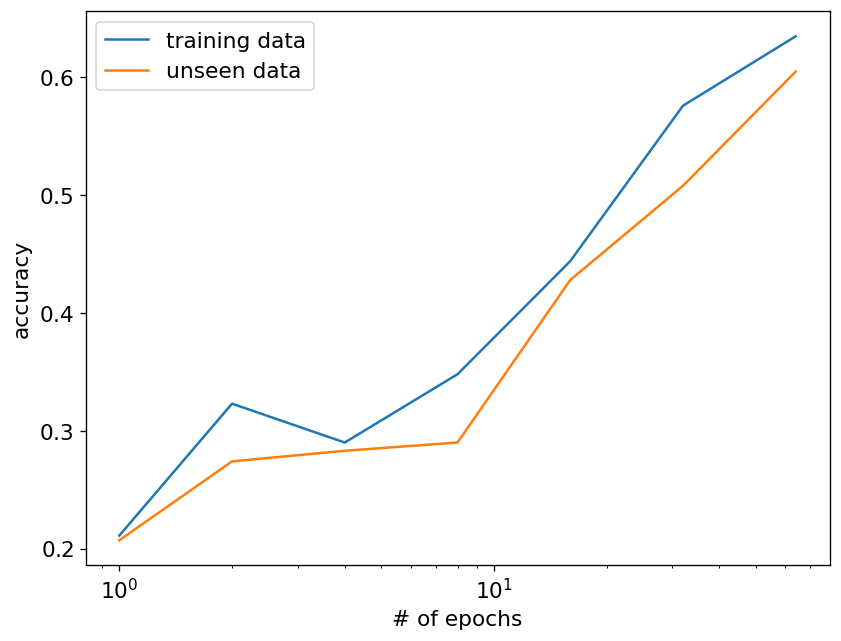

In [10]:
fig, ax = plt.subplots()

ax.plot(n_epochs, accuracy_trained, label="training data")
ax.plot(n_epochs, accuracy_unseen, label="unseen data")
ax.set_xscale("log")
ax.set_xlabel("# of epochs")
ax.set_ylabel("accuracy")
ax.legend()

### Effect of the training sample size

Now let's vary the size of the training sample

In [11]:
ntrain = [10, 30, 100, 300, 1000, 3000, 10000]
accuracy_trained = []
accuracy_unseen = []

for nt in ntrain:
    nn = NeuralNetwork(num_training_unique=nt,
                       hidden_layer_size=50, data_class=ModelDataCategorical)    
    nn.train(n_epochs=50)
    accuracy_trained.append(nn.check_accuracy())
    accuracy_unseen.append(nn.test_unseen())    

Text(0, 0.5, 'accuracy')

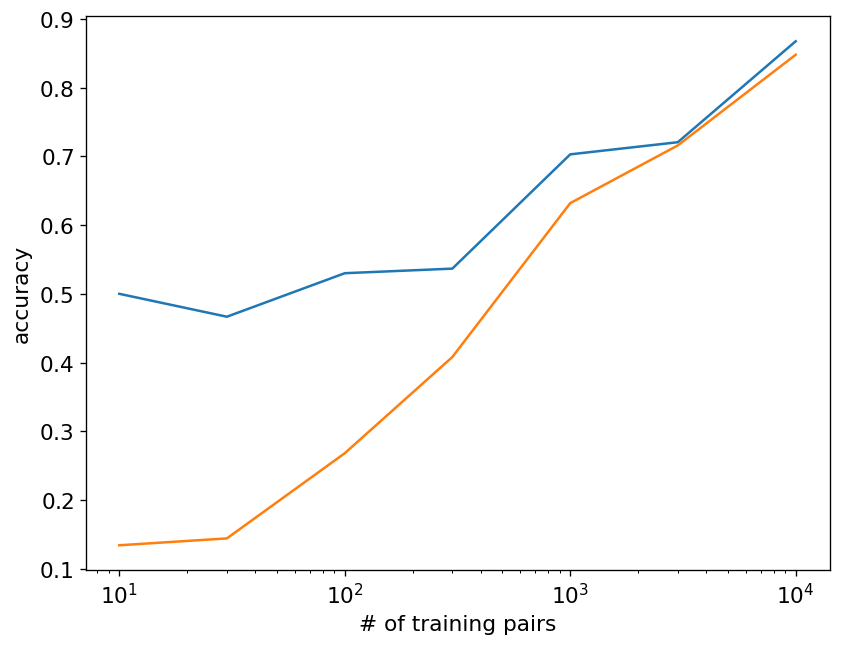

In [12]:
fig, ax = plt.subplots()

ax.plot(ntrain, accuracy_trained, label="training data")
ax.plot(ntrain, accuracy_unseen, label="unseed data")
ax.set_xscale("log")
ax.set_xlabel("# of training pairs")
ax.set_ylabel("accuracy")

## Effect of hidden layer size

In [13]:
nhidden = [5, 10, 20, 50, 100, 200]
accuracy_trained = []
accuracy_unseen = []

for nh in nhidden:
    nn = NeuralNetwork(num_training_unique=1000,
                       hidden_layer_size=nh, data_class=ModelDataCategorical)    
    nn.train(n_epochs=100)
    accuracy_trained.append(nn.check_accuracy())
    accuracy_unseen.append(nn.test_unseen())    

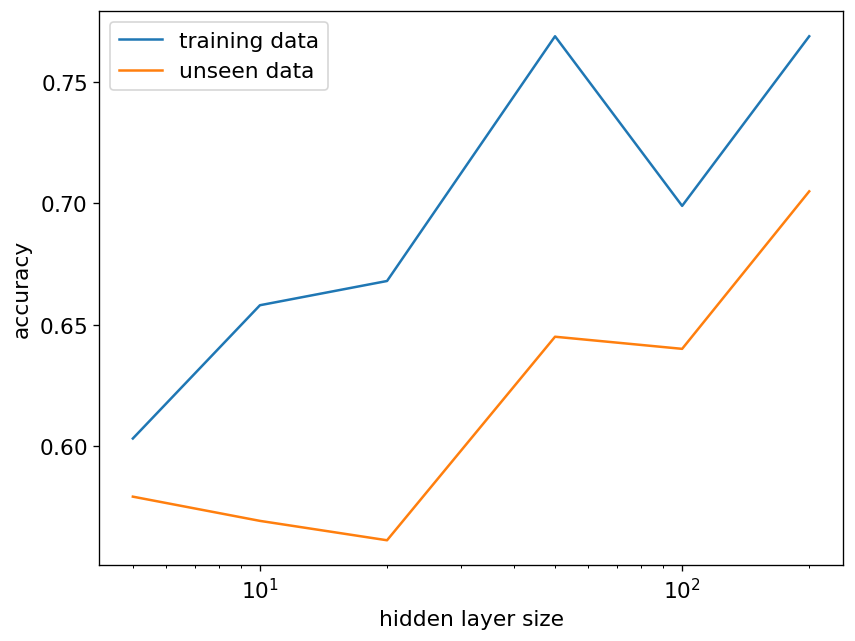

In [14]:
fig, ax = plt.subplots()

ax.plot(nhidden, accuracy_trained, label="training data")
ax.plot(nhidden, accuracy_unseen, label="unseen data")
ax.set_xscale("log")
ax.set_xlabel("hidden layer size")
ax.set_ylabel("accuracy")
ax.legend()

By far the best improvement we can get for unseen data is to train it on a larger number of training data pairs.  If we show it more variety, then it is not overconstraining to just the data that it has seen.

In [24]:
nn = NeuralNetwork(num_training_unique=10000,
                   hidden_layer_size=60, data_class=ModelDataCategorical)
nn.train(n_epochs=20)

In [25]:
nn.check_accuracy()

0.851

In [26]:
nn.test_unseen()

0.856